In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import findspark
findspark.init()
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, pandas_udf,col, lower, regexp_replace
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, ArrayType
from pyspark.ml.feature import CountVectorizer, StringIndexer, Tokenizer, StopWordsRemover
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix
from pyspark.ml import PipelineModel, Pipeline, Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.ml.util import DefaultParamsWritable, DefaultParamsReadable


nltk.download('stopwords')
nltk.download('punkt')

# Define English stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\84369\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\84369\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Text Classification with PySpark") \
    .getOrCreate()

In [3]:
# Load the data
data = spark.read.csv('data/twitter_training.csv', header=False, inferSchema=True)
validation = spark.read.format("csv") \
    .option("header", False) \
    .option("multiLine", True) \
    .option("escape", '"') \
    .option("inferSchema", True) \
    .load("data/twitter_validation.csv")

In [4]:
data.count(), validation.count()

(74682, 1000)

In [5]:
# Define column names
columns = ['id', 'Topic', 'Label', 'Text']

# Rename columns
for i, col in enumerate(columns):
    data = data.withColumnRenamed('_c{}'.format(i), col)
    validation = validation.withColumnRenamed('_c{}'.format(i), col)

In [6]:
# Kiểm tra số lượng giá trị Null hoặc rỗng trong cột Label gốc
print("Nulls in Label of validation:", validation.filter(validation["Label"].isNull()).count())
print("Empty strings in Label of validation:", validation.filter(validation["Label"] == "").count())

print("Nulls in Label of data:", data.filter(data["Label"].isNull()).count())
print("Empty strings in Label of data:", data.filter(data["Label"] == "").count())

Nulls in Label of validation: 0
Empty strings in Label of validation: 0
Nulls in Label of data: 0
Empty strings in Label of data: 0


In [7]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Topic: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- Text: string (nullable = true)



In [8]:
# Drop rows with empty 'Text' column
data = data.dropna(subset=['Text'])
validation = validation.dropna(subset=['Text'])

In [9]:
validation.select("*").show(10)

+-----+--------------------+----------+--------------------+
|   id|               Topic|     Label|                Text|
+-----+--------------------+----------+--------------------+
| 3364|            Facebook|Irrelevant|I mentioned on Fa...|
|  352|              Amazon|   Neutral|BBC News - Amazon...|
| 8312|           Microsoft|  Negative|@Microsoft Why do...|
| 4371|               CS-GO|  Negative|CSGO matchmaking ...|
| 4433|              Google|   Neutral|Now the President...|
| 6273|                FIFA|  Negative|Hi @EAHelp I’ve h...|
| 7925|           MaddenNFL|  Positive|Thank you @EAMadd...|
|11332|TomClancysRainbowSix|  Positive|Rocket League, Se...|
| 1107|      AssassinsCreed|  Positive|my ass still knee...|
| 2069|          CallOfDuty|  Negative|FIX IT JESUS ! Pl...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [10]:
# Define the StringIndexer for the label column (index the labels)
label_indexer = StringIndexer(inputCol="Label", outputCol="Label2")

# # Define your index mapping
# class_index_mapping = { "Negative": 0, "Positive": 1, "Neutral": 2, "Irrelevant": 3 }

# Fit StringIndexer on data
label_indexer_model = label_indexer.fit(data)
data = label_indexer_model.transform(data)
validation = label_indexer_model.transform(validation)

# Extract label mapping
label_mapping = label_indexer_model.labels

# Print label mapping
print("Label Mapping:")
for index, label in enumerate(label_mapping):
    print(f"Index {index} --> Label '{label}'")

Label Mapping:
Index 0 --> Label 'Negative'
Index 1 --> Label 'Positive'
Index 2 --> Label 'Neutral'
Index 3 --> Label 'Irrelevant'


In [11]:
def clean_text(df, inputCol="Text", outputCol="cleaned_text"):
    # Remove links starting with https://, http://, www., or containing .com
    df = df.withColumn(outputCol, regexp_replace(df[inputCol], r'https?://\S+|www\.\S+|S+\.com\S+|youtu\.be/\S+', ''))
    # Remove words starting with # or @
    df = df.withColumn(outputCol, regexp_replace(df[outputCol], r'(@|#)\w+', ''))
    # Convert text to lowercase
    df = df.withColumn(outputCol, lower(df[outputCol]))
    # Remove non-alpha characters
    df = df.withColumn(outputCol, regexp_replace(df[outputCol], r'[^a-zA-Z\s]', ''))
    
    return df

In [12]:
cleaned_data = clean_text(data, inputCol="Text", outputCol="Text")
cleaned_validation = clean_text(validation, inputCol="Text", outputCol="Text")

In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, StructField, StructType
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark import keyword_only
from pyspark.ml.util import DefaultParamsWritable, DefaultParamsReadable

# Định nghĩa một Transformer tùy chỉnh để lọc chuỗi rỗng
class EmptyStringFilter(Transformer, HasInputCol, HasOutputCol, DefaultParamsWritable, DefaultParamsReadable):
    """
    Lọc bỏ các chuỗi rỗng ("") và None khỏi mảng tokens.
    """
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(EmptyStringFilter, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):
        input_col = self.getInputCol()
        output_col = self.getOutputCol()
        
        # Hàm UDF để thực hiện việc lọc
        def filter_empty_tokens(tokens):
            if tokens is None:
                return []
            # Lọc bỏ các token là None, hoặc chuỗi rỗng/khoảng trắng
            return [token for token in tokens if token and token.strip()]

        filter_udf = udf(filter_empty_tokens, ArrayType(StringType(), containsNull=False))
        
        return dataset.withColumn(output_col, filter_udf(dataset[input_col]))

    def copy(self, extra=None):
        if extra is None:
            extra = {}
        return self.defaultCopy(extra)

In [14]:
# 1. Định nghĩa các thành phần cũ (Giữ nguyên)
tokenizer = Tokenizer(inputCol="Text", outputCol="tokens")
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=stop_words)

# 2. Định nghĩa Transformer mới để lọc (Sử dụng lớp đã tạo ở Bước 1)
# Đặt tên cột đầu ra mới để đảm bảo tính rõ ràng
empty_string_filter = EmptyStringFilter(inputCol="filtered_tokens", outputCol="final_tokens")

# 3. Định nghĩa CountVectorizer (Dùng cột đầu vào mới)
count_vectorizer = CountVectorizer(inputCol="final_tokens", outputCol="features", vocabSize=10000, minDF=5)

# 4. Định nghĩa Logistic Regression (Giữ nguyên)
lr = LogisticRegression(maxIter=10, labelCol="Label2", featuresCol="features")

# 5. Xây dựng Pipeline mới
# LƯU Ý: Thêm 'empty_string_filter' vào stages
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, empty_string_filter, count_vectorizer, lr])

# Áp dụng Pipeline
model = pipeline.fit(cleaned_data)
processed_data = model.transform(cleaned_data)

In [15]:
processed_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Topic: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- Label2: double (nullable = false)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- final_tokens: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [16]:
processed_data.select("Text", "Label2", "prediction").show()

+--------------------+------+----------+
|                Text|Label2|prediction|
+--------------------+------+----------+
|im getting on bor...|   1.0|       1.0|
|i am coming to th...|   1.0|       1.0|
|im getting on bor...|   1.0|       1.0|
|im coming on bord...|   1.0|       1.0|
|im getting on bor...|   1.0|       1.0|
|im getting into b...|   1.0|       1.0|
|so i spent a few ...|   1.0|       1.0|
|so i spent a coup...|   1.0|       1.0|
|so i spent a few ...|   1.0|       1.0|
|so i spent a few ...|   1.0|       1.0|
| so i spent a few...|   1.0|       1.0|
|                 was|   1.0|       0.0|
|rockhard la varlo...|   2.0|       2.0|
|rockhard la varlo...|   2.0|       2.0|
|rockhard la varlo...|   2.0|       2.0|
|rockhard la vita ...|   2.0|       2.0|
|live rock  hard m...|   2.0|       2.0|
|ihard like me rar...|   2.0|       2.0|
|that was the firs...|   1.0|       1.0|
|this was the firs...|   1.0|       1.0|
+--------------------+------+----------+
only showing top

In [ ]:
# Save the model
model.write().overwrite().save("logistic_regression_model_spark")

In [17]:
from pyspark.ml import PipelineModel

# Load the model
loaded_model = PipelineModel.load("logistic_regression_model_spark")

In [18]:
cleaned_validation.select('*').show(10)

+-----+--------------------+----------+--------------------+------+
|   id|               Topic|     Label|                Text|Label2|
+-----+--------------------+----------+--------------------+------+
| 3364|            Facebook|Irrelevant|i mentioned on fa...|   3.0|
|  352|              Amazon|   Neutral|bbc news  amazon ...|   2.0|
| 8312|           Microsoft|  Negative| why do i pay for...|   0.0|
| 4371|               CS-GO|  Negative|csgo matchmaking ...|   0.0|
| 4433|              Google|   Neutral|now the president...|   2.0|
| 6273|                FIFA|  Negative|hi  ive had madel...|   0.0|
| 7925|           MaddenNFL|  Positive|thank you  \n\nne...|   1.0|
|11332|TomClancysRainbowSix|  Positive|rocket league sea...|   1.0|
| 1107|      AssassinsCreed|  Positive|my ass still knee...|   1.0|
| 2069|          CallOfDuty|  Negative|fix it jesus  ple...|   0.0|
+-----+--------------------+----------+--------------------+------+
only showing top 10 rows



In [19]:
processed_validation = loaded_model.transform(cleaned_validation)

In [20]:
processed_validation.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Topic: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- Label2: double (nullable = false)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- final_tokens: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [21]:
# Apply the pipeline to the new data
processed_validation = loaded_model.transform(cleaned_validation)

# Optionally, you can select specific columns for evaluation
selected_data = processed_validation.select("id", "Text", "prediction", "Label2")

# Show the processed data
selected_data.show()

+-----+--------------------+----------+------+
|   id|                Text|prediction|Label2|
+-----+--------------------+----------+------+
| 3364|i mentioned on fa...|       3.0|   3.0|
|  352|bbc news  amazon ...|       2.0|   2.0|
| 8312| why do i pay for...|       0.0|   0.0|
| 4371|csgo matchmaking ...|       0.0|   0.0|
| 4433|now the president...|       2.0|   2.0|
| 6273|hi  ive had madel...|       0.0|   0.0|
| 7925|thank you  \n\nne...|       1.0|   1.0|
|11332|rocket league sea...|       1.0|   1.0|
| 1107|my ass still knee...|       1.0|   1.0|
| 2069|fix it jesus  ple...|       0.0|   0.0|
| 3185|the professional ...|       1.0|   1.0|
| 1172|itching to assass...|       1.0|   1.0|
|11783| hey fred comcast...|       0.0|   0.0|
| 4286|csgo wingman im s...|       2.0|   2.0|
| 8431| game sucks down ...|       0.0|   0.0|
| 9135|congrats to the n...|       1.0|   1.0|
| 4822|    yeah and its fun|       1.0|   1.0|
| 3068|       fuck my life |       0.0|   0.0|
|10537|happy 

Accuracy: 0.924
Confusion Matrix:


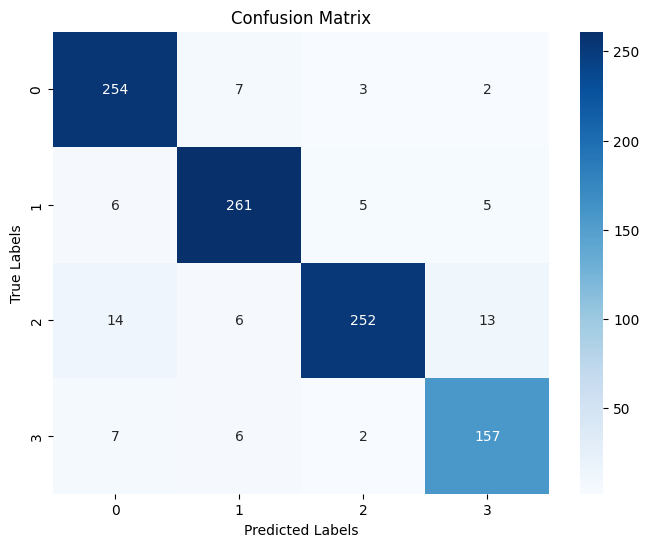

In [22]:
# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Label2", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(processed_validation)
print("Accuracy:", accuracy)

# --- Create a confusion matrix

# Convert Spark DataFrame to Pandas DataFrame
prediction_and_label_pd = processed_validation.select("prediction", "Label2").toPandas()

# Extract predicted labels and true labels
predicted_labels = prediction_and_label_pd["prediction"].tolist()
true_labels = prediction_and_label_pd["Label2"].tolist()

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [23]:
# Stop SparkSession
spark.stop()